In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

from scipy.optimize import brentq

from lightshifts.consts import h, hbar, c, eps0
from lightshifts.auxiliary import smart_gen_array, laser_intensity, \
                        plot_total_lightshift_around_hyperfine_state,\
                        plot_scalar_lightshift
import lightshifts.lightshift_solver as ls

## Calculate potential for the clock states 1S0, 3P0 and for 3P1

** Transitions relevant for clock states and intercombination line light shift **

In [3]:
#import transition data
ls_1S0 = ls('atom_yb173.json', 'transitions_1S0.json')
ls_3P0 = ls('atom_yb173.json', 'transitions_3P0.json')
ls_3P1 = ls('atom_yb173.json', 'transitions_3P1.json')

** find magic wavelength **

In [4]:
lambda_m = brentq(lambda w: ls_3P0.scalar_polarizability(w) \
       - ls_1S0.scalar_polarizability(w), 660*1e-9, 800*1e-9)
print('magic wavelength is %1.2f nm'%(lambda_m*1e9))

magic wavelength is 723.99 nm


lattice depth there in kHz/(W/cm^2)

In [5]:
print('lattice depth is %1.2f Hz/(W/cm^2)'%ls_1S0.scalar_lightshift(lambda_m))

lattice depth is -8.90 Hz/(W/cm^2)


for a given laser beam (L3)

In [6]:
laser_power = 100e-3 #in Watts
beam_waist  = 127e-6 #in meters
l_int = laser_intensity(laser_power, beam_waist)
print('lattice depth for %1.2f W/cm^2 is %1.2f Hz'%(l_int, ls_1S0.scalar_lightshift(lambda_m, l_int)))

lattice depth for 394.71 W/cm^2 is -3512.87 Hz


** SDL polarizability ratio **

In [7]:
lambda_sdl = 670e-9
ls_3P0.scalar_lightshift(lambda_sdl)/ls_1S0.scalar_lightshift(lambda_sdl)

3.00761751831238

**Yellow probe light shift** 

In [8]:
lambda_clock = 578e-9
clock_laser_intensity = laser_intensity(laser_power=50e-3, beam_waist=127e-6)
probe_shift = ls_3P0.scalar_lightshift(lambda_clock, clock_laser_intensity)\
             -ls_1S0.scalar_lightshift(lambda_clock, clock_laser_intensity)

print('yellow probe shift for %1.2f W/cm^2 is %1.2f Hz'%(clock_laser_intensity, 
                                                         probe_shift))

yellow probe shift for 197.35 W/cm^2 is 3293.50 Hz


** generate and plot light shift table for clock states and 3P1 **

(-100, 100)

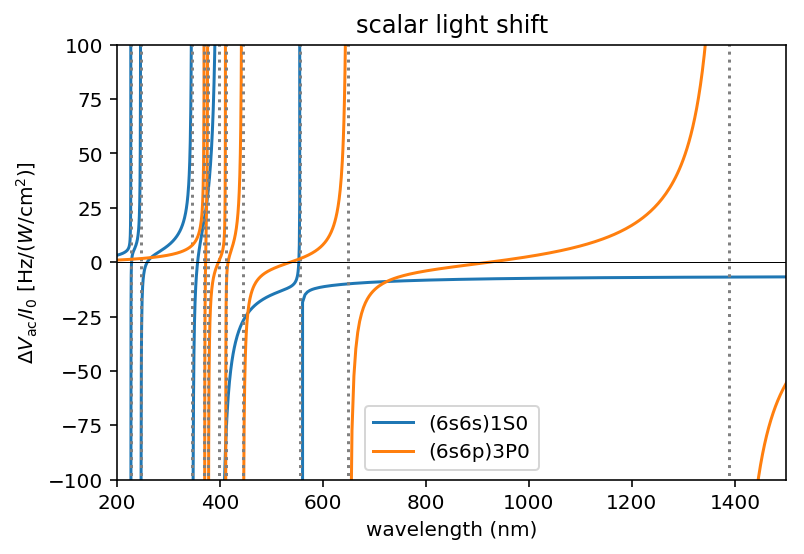

In [9]:
plot_scalar_lightshift('atom_yb173.json', 'transitions_1S0.json')
plot_scalar_lightshift('atom_yb173.json', 'transitions_3P0.json')
plt.ylim(-100,100)

## OSG ground state polarizability including vector and tensor shifts

In [ ]:
plt.figure(figsize=(9,6))
plot_total_lightshift_around_hyperfine_state('atom_yb173.json', 'transitions_1S0.json',
                                       ['6s6p','3P1'], Ff=7/2, q=1,
                                       df_min=10e9, df_max=10e9, n=100)
plt.ylim(-100e3,100e3)
plt.show()

In [ ]:
plt.figure(figsize=(9,6))
plot_total_lightshift_around_hyperfine_state('atom_yb173.json', 'transitions_1S0.json',
                                       ['6s6p','3P1'], Ff=7/2, q=0,
                                       df_min=10e9, df_max=10e9, n=100)
plt.ylim(-100e3,100e3)
plt.show()

## "Repumper OSG" excited clock state polarizability including vector and tensor shifts

In [ ]:
plt.figure(figsize=(9,6))
plot_total_lightshift_around_hyperfine_state('atom_yb173.json', 'transitions_3P0.json',
                                       ['6s5d','3D1'], Ff=3/2, q=1, 
                                       df_min=10e9, df_max=10e9, n=100)
plt.ylim(-1e6,1e6)
plt.show()

In [ ]:
plt.figure(figsize=(9,6))
plot_total_lightshift_around_hyperfine_state('atom_yb173.json', 'transitions_3P0.json',
                                       ['6s5d','3D1'], Ff=3/2, q=0, 
                                       df_min=10e9, df_max=10e9, n=100)
plt.ylim(-1e6,1e6)
plt.show()